In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import ( StandardScaler, 
                                   PolynomialFeatures,
                                   MinMaxScaler)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from utils import show_heat_map, clean_data, create_features, get_model_train_stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data=pd.read_csv('https://raw.githubusercontent.com/TeamEpicProjects/Taxi_Fare_Prediction/main/Data/Process%20Data/Cleaned%202017%20Green%20data.csv')

stats_df = pd.DataFrame(columns=
                      ['Model Name', 'Explained Variance', 'Maximum Error', 'Mean Absolute Error', 'Mean Squared Error', 'Mean Squared Log Error', 'Meadian Absolute Error', 'R2 Value', 'Mean Poisson Deviance', 'Mean Gamma Deviance'])
stats_df.set_index('Model Name', inplace=True)

In [6]:
## Cleaning data and Feature Selection 
data = clean_data(data)
data = create_features(data)

# round off pickup time and distance for faster processing
data['rounded_pickup_time'] = data['lpep_pickup_datetime'].round('30T')
data['rounded_trip_distance'] = round(data['trip_distance'],0)


In [7]:
data_grouped = pd.DataFrame(data.groupby(by=['PULocationID','day_of_week','hour_of_day'])['VendorID'].count())
data_grouped.columns = ['Count']
data_grouped.reset_index(inplace=True)

## Testing Polynomial Regression with 2018 Data

In [8]:
# Model Prep - training testing sets - 75-25 split

data_excerpt = data[['trip_duration','trip_distance','hour_of_day','day_of_week','fare_amount']]
train_sample_size = int(data_excerpt.shape[0]*0.75)
train_data = data_excerpt.iloc[:train_sample_size]
test_data  = data_excerpt[train_sample_size:]

print('Train: ',train_data.shape," Test: ",test_data.shape)

X_train, X_test = train_data.drop(['fare_amount'],1) , test_data.drop(['fare_amount'],1)
Y_train, Y_test = train_data['fare_amount'], test_data['fare_amount']

Train:  (57059, 5)  Test:  (19020, 5)


In [9]:
data_2018 = pd.read_csv('https://raw.githubusercontent.com/TeamEpicProjects/Taxi_Fare_Prediction/main/Data/Process%20Data/Cleaned%202018%20Green%20data.csv')
data_2018 = clean_data(data_2018)
data_2018 = create_features(data_2018)
data_2018_excerpt = data_2018[['trip_duration','trip_distance','hour_of_day','day_of_week','fare_amount']]

In [10]:
X=data_2018_excerpt.drop(['fare_amount'],1)
Y=data_2018_excerpt['fare_amount']

poly_reg = make_pipeline(PolynomialFeatures(2),StandardScaler(),LinearRegression())
poly_reg.fit(X,Y)
Y_predicted = poly_reg.predict(X)

stats, stats_df = get_model_train_stats(Y,Y_predicted,'Poly Regression-2018', stats_df)
print(stats)

-------------------------------------------------
       REPORT for Poly Regression-2018
-------------------------------------------------
Explained Variance : 0.9526790246076401
Maximum Error : 203.87204330970047
Mean Absolute Error : 1.6047743209299807
Mean Squared Error : 17.089999349630705
Mean Squared Log Error : 0.00555877929349999
Meadian Absolute Error : 0.8111485999757821
R2 Value : 0.9526790246076401
Mean Poisson Deviance : 0.25698730852237356
Mean Gamma Deviance : 0.008020586690157238
-------------------------------------------------



In [11]:
X = data_excerpt.drop(['fare_amount'], 1)
Y = data_excerpt['fare_amount']
Y_predicted = poly_reg.predict(X)
stats, stats_df = get_model_train_stats(Y, Y_predicted, 'Poly Regression-2017', stats_df)
print(stats)

-------------------------------------------------
       REPORT for Poly Regression-2017
-------------------------------------------------
Explained Variance : 0.9120675433789415
Maximum Error : 323.73294475601415
Mean Absolute Error : 1.60051867870984
Mean Squared Error : 25.07528542236877
Meadian Absolute Error : 0.7222474733535478
R2 Value : 0.9119813629016674
-------------------------------------------------



## Testing Polynomial Regression with 2019 Data

In [12]:
data_2019 = pd.read_csv('https://raw.githubusercontent.com/TeamEpicProjects/Taxi_Fare_Prediction/main/Data/Process%20Data/Cleaned%202019%20Green%20data.csv')
data_2019 = clean_data(data_2019)
data_2019 = create_features(data_2019)
data_2019_excerpt = data_2019[['trip_duration','trip_distance','hour_of_day','day_of_week','total_amount']]
X=data_2019_excerpt.drop(['total_amount'], 1)
Y=data_2019_excerpt['total_amount']
Y_predicted = poly_reg.predict(X)
stats, stats_df = get_model_train_stats(Y, Y_predicted, 'Poly Regression-2019', stats_df)
print(stats)

-------------------------------------------------
       REPORT for Poly Regression-2019
-------------------------------------------------
Explained Variance : 1.0
Maximum Error : 7.994327022514067
Mean Absolute Error : 7.994327022514067
Mean Squared Error : 63.90926454289863
Mean Squared Log Error : 0.09196790585242531
Meadian Absolute Error : 7.994327022514067
R2 Value : nan
Mean Poisson Deviance : 2.3885099757479864
Mean Gamma Deviance : 0.08975035787197072
-------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Data Stationarity - Hypothesis Testing (Time Series Hypothesis)


#### <b>Null Hypothesis(H0):</b> Data is non-stationary<br>
#### <b>Alternate Hypothesis(H1):</b> Data is stationary

In [13]:
result = adfuller(data['fare_amount'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value, label in zip(result, labels):
    print(label+' : '+str(value) )

ADF Test Statistic : -38.14187208182454
p-value : 0.0
#Lags Used : 34
Number of Observations : 76044


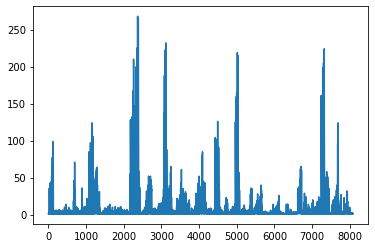

In [14]:
data_grouped['Count'].plot()

p-value is less than 0.05 suggesting evidence against H0, leading to a rejection in H0<br>
<font color="blue">Data is stationary</font>

### Checking for Autocorrelation(Extra)

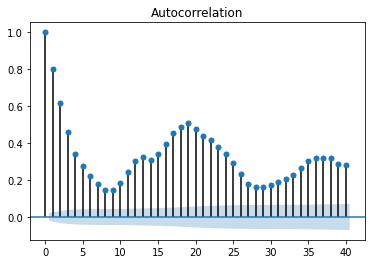

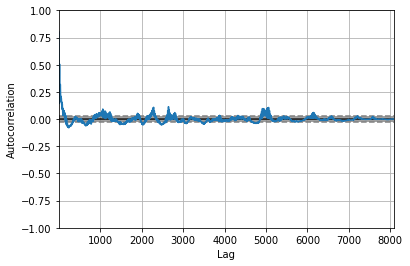

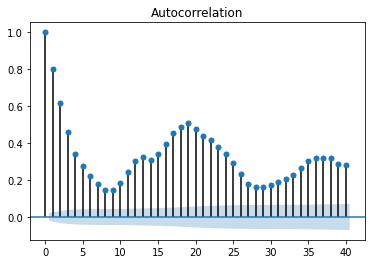

In [15]:
data['unix_time'] = pd.to_datetime(data['rounded_pickup_time']).astype(int) / 10**9
autocorrelation_plot(data_grouped['Count'])
plot_acf(data_grouped['Count'])

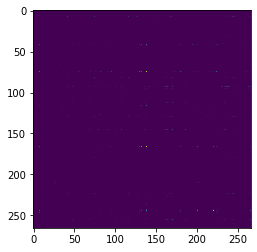

In [16]:
# preparing the weight matrix
pt=pd.pivot_table(data, index=['PULocationID','DOLocationID'], aggfunc='count')
num_rows = max((pt.index.get_level_values(0)))+1
num_cols = max((pt.index.get_level_values(1)))+1
array=np.array([[0]*num_cols]*num_rows)
for index, row in pt.iterrows():
  array[index[0]][index[1]] = row['VendorID']
plt.imshow(array, interpolation='none')
plt.show()

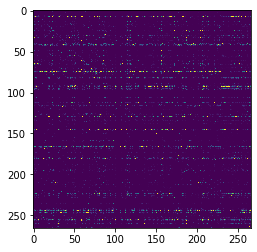

In [17]:
minMaxScaler = MinMaxScaler((0,255))
array1 = minMaxScaler.fit_transform(array)
plt.imshow(array1, interpolation='none')
plt.show()